# **Transformer 原理跟算法**


<br>
  <a href="https://colab.research.google.com/drive/1imMmP6jDZ80Ih7Gw4gKSHlL5SqBhEvFD?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<br>
(聲明：以下內容都是在網路上整理並修改的，真正我原創的內容並不多，我主要只是搬運工)


此文章為[Transformer from scratch using pytorch](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch)根據我的理解的中文版本。

有錯的話請通知我
1. 介紹
2. 導入庫
3. 基本組件
4. 創建詞嵌入（Word Embeddings）
5. 位置編碼（Positional Encoding）
6. 自注意力機制（Self Attention）
7. 編碼器（Encoder）
8. 解碼器（Decoder）
8. 測試我們的代碼
9. 一些有用的資源

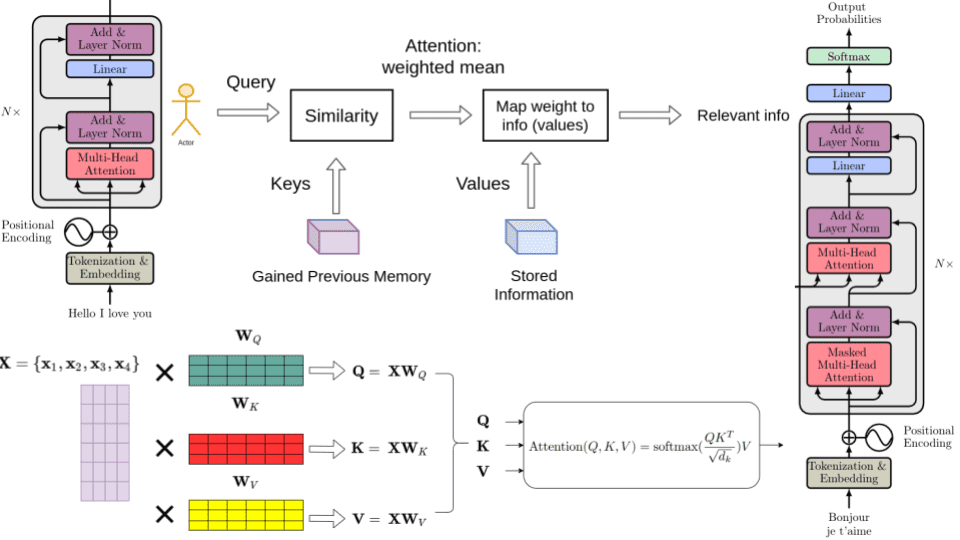

# 1.介紹
在本教程中，將會嘗試使用PyTorch從頭開始實現“Attention is All You Need”論文中的Transformers。基本上，Transformer採用了一種編碼器-解碼器架構，現在此架構在語言翻譯模型中很常見。
注意：在此，我們不會深入解釋Transformers。對此，請參考[Jay Alammar](http://jalammar.github.io/illustrated-transformer/)的博客。(英文苦手的話裏面blog也有中文翻譯的連結)他對Transformers的內部工作原理給予了深入的解釋。我們將僅專注於編碼部分。

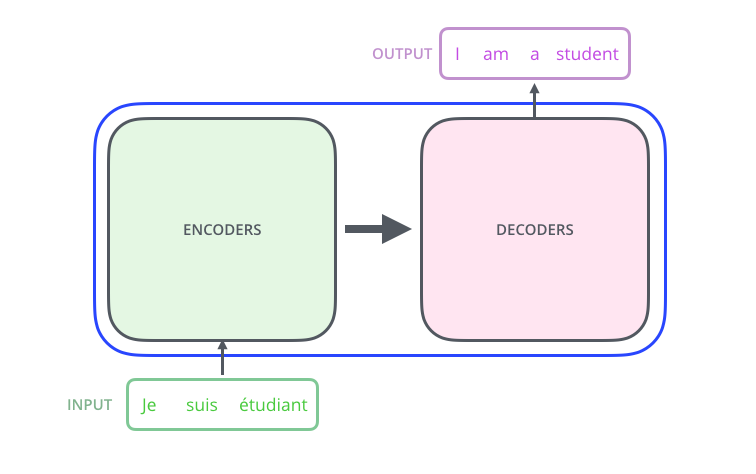

上面的圖像顯示了一個從法語到英語的語言翻譯模型。實際上，我們可以使用編碼器的堆疊（每個編碼器的輸出）和解碼器的堆疊，如下所示：



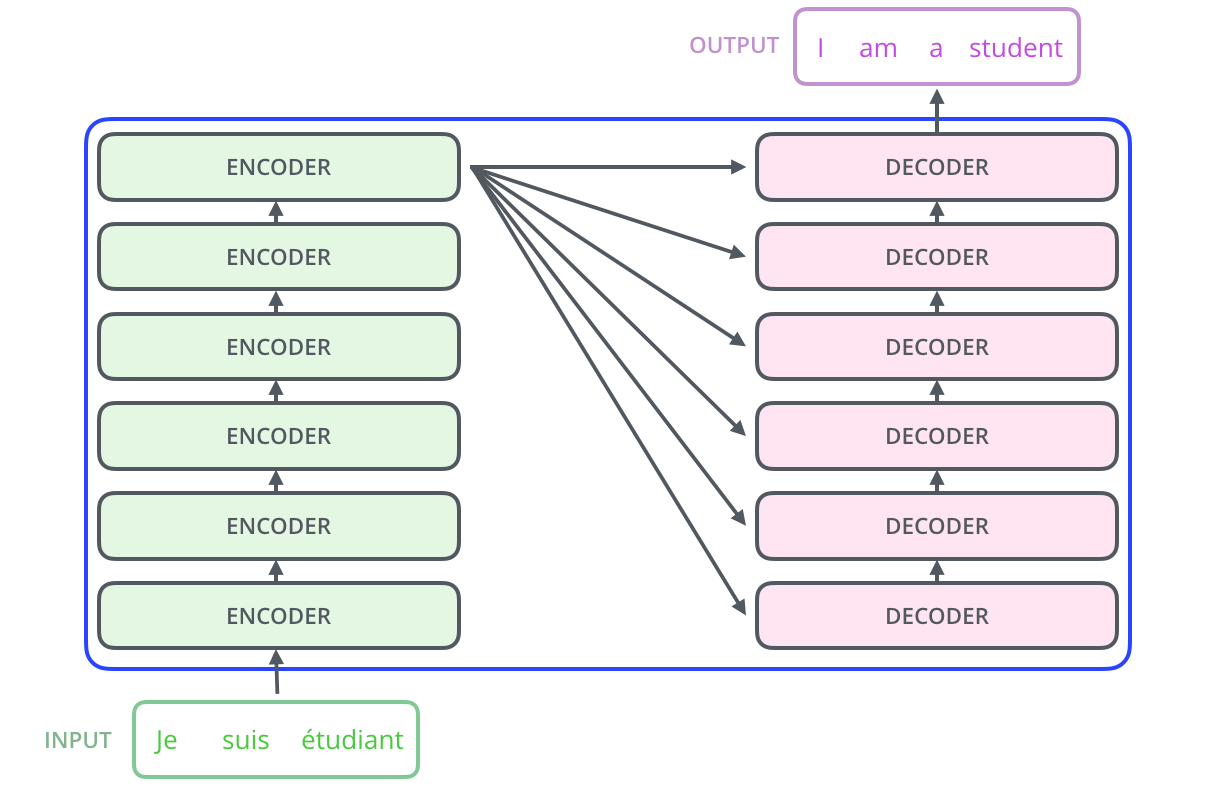

在進一步了解之前，這邊先看一下這邊實現注意力模型的完整圖像。


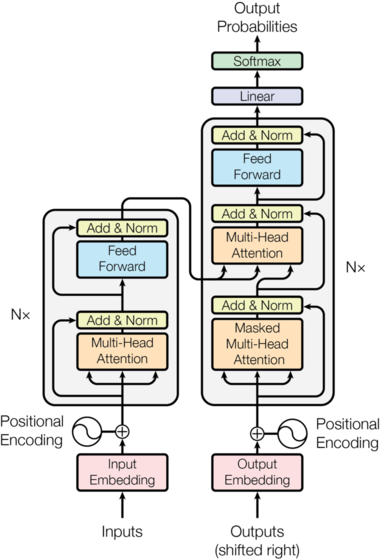

# 2.導入庫


In [1]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

2.0.1+cu118


對於語言翻譯，Transformer 有一個編碼器解碼器架構。在深入編碼器或解碼器之前，這邊先介紹下一些常見的組件。

# **3.基本組件**



##**創建詞嵌入：**

首先，我們需要將輸入序列中的每個詞轉換為一個嵌入向量。嵌入向量將為每個詞創建一個更語義化的表示。

假設每個嵌入向量的維度為512，假設我們的詞彙量大小為100，那麼我們的嵌入矩陣將是100x512的大小。這些矩陣將在訓練過程中被學習，並且在推論過程中，每個詞將被映射到相應的512維向量。假設我們有批量大小為32，並且序列長度為10（10個詞）。那麼輸出將是32x10x512。

In [2]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

## **位置編碼**

下一步是生成位置編碼。為了讓模型理解句子，它需要知道每個詞的兩件事：

* 這個詞是什麼意思？
* 這個詞在句子中的位置是什麼？

在 "Attention is All You Need" 這篇論文中，作者使用了以下函數來創建位置編碼。在奇數時間步，使用餘弦函數，而在偶數時間步，使用正弦函數。
同學, 國中數學思密達

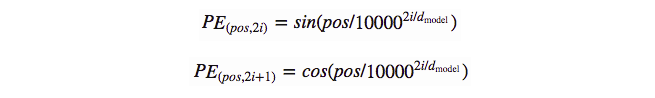

pos -> 指的是在句子中的順序

i -> 指的是嵌入向量的位置

位置嵌入向量將會生成一個類似於嵌入矩陣的矩陣向量。它將創建一個維度為序列長度 x 嵌入維度的矩陣。對於序列中的每個標記（單詞），我們將找到維度為 1 x 512 的嵌入向量，並將其與維度為 1 x 512 的相應位置向量相加，以獲得每個單詞/標記的 1 x 512 維輸出。

例如：如果我們的批次大小為 32，序列長度為 10，並且讓嵌入維度為 512。那麼我們將有維度為 32 x 10 x 512 的嵌入向量。同樣，我們將有維度為 32 x 10 x 512 的位置編碼向量。然後我們將兩者相加。

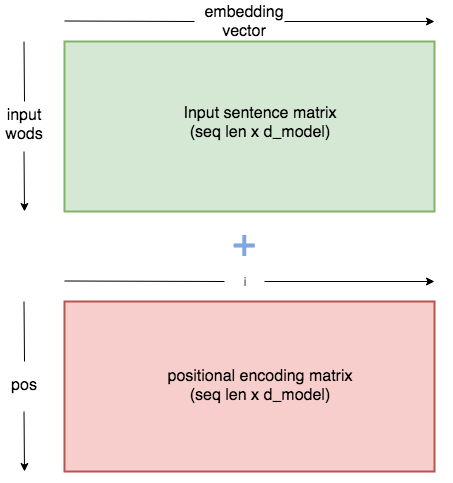

In [3]:
# 在 Pytorch 中註冊 Buffer ->
# 如果你的模型中有參數，這些參數應該在 state_dict 中被保存和恢復，,
# 但是不應該被optimizer訓練，那麼你應該將它們註冊為buffer。

class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """

        # make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

## **自我注意力**

這邊簡單介紹一下自我注意力和多頭注意力。

**什麼是自我注意力？**

假設我們有一個句子 “狗正在過馬路，因為它看到了廚房”。這裡的 “它” 指的是什麼？對人類來說，很容易理解 “它” 是指 “狗”。但對機器來說，並不容易。

當模型處理每個單詞時，自我注意力允許它查看輸入序列中的其他位置以獲取線索。它將根據每個單詞與其他單詞的依賴關係創建一個向量。

讓我們逐步說明自我注意力的計算過程。

* **步驟 1**：

計算自注意力(self-attention)的第一步是從編碼器的每個輸入向量（在這種情況下，是每個單詞的嵌入向量）創建三個向量。所以對於每個單詞，我們創建一個查詢向量(Query vector)，一個鍵向量(Key vector)，和一個值向量(Value vector)。每個向量的維度將為 1x64。 由於我們有多頭注意力，我們將有 8 個自注意力頭。我將以 8 個注意力頭為例來解釋代碼。


以下是我的理解，有錯請跟我說。

『
向量(Query vector):可以理解為一個字詞的多維特徵(可類比人的臉)

鍵向量(Key vector):可以理解為要抽取的特定方向

值向量(Value vector)：抽取處理出來的矩陣特徵

8 個注意力頭：這邊大概是論文作者把人類一次只能記住7~10個長度的東西侷限當作參考。』


**如何創建鍵、查詢和值？**

我們將有一個鍵矩陣，查詢矩陣和值矩陣來生成鍵，查詢和值。這些矩陣在訓練過程中是學習得到的。

程式碼提示： 假設我們有批次大小為32，序列長度為10，嵌入維度為512。所以在嵌入和位置編碼後，我們的輸出將為32x10x512的維度。 我們將其調整為32x10x8x64的維度。（關於8，它是多頭注意力中的頭的數量。不用擔心，一旦你閱讀過程式碼，你就會知道它是什麼。）。

* 步驟 2：

第二步是計算得分。也就是，我們將查詢矩陣與鍵矩陣相乘。[Q x K・t]

假設我們的鍵、查詢和值維度為32x10x8x64。在進一步處理之前，我們將對它們進行轉置以便於乘法運算（32x8x10x64）。現在將查詢矩陣與鍵矩陣的轉置相乘。即 (32x8x10x64) x (32x8x64x10) -> (32x8x10x10)。

* 步驟3：

現在將輸出矩陣除以鍵矩陣維度的平方根，然後對其應用Softmax。

程式碼提示：我們將32x8x10x10向量除以8，即64（鍵矩陣的維度）的平方根

* 步驟4：

然後將其與值矩陣相乘。

程式碼提示： 步驟3之後，我們的輸出將為32x8x10x10維度。現在將其與值矩陣（32x8x10x64）相乘，得到輸出維度為（32x8x10x64）。這裡8是注意力頭的數量，10是序列長度。因此，對於每個單詞，我們都有64維向量。

* 步驟5：

一旦我們有了這個，我們將通過一個線性層傳遞它。這形成了多頭注意力的輸出。

程式碼提示： （32x8x10x64）向量被轉置為（32x10x8x64），然後重塑為（32x10x512）。然後它通過一個線性層得到（32x10x512）的輸出。

現在你對多頭注意力的工作原理有了一個概念。一旦你通過它的實現部分，你會更清楚。

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d

        #key,query and value matrixes    #64 x 64
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim)

    def forward(self,key,query,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512

        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder

        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)

        # query dimension can change in decoder during inference.
        # so we cant take general seq_length
        seq_length_query = query.size(1)

        # 32x10x512
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim) #(32x10x8x64)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)

        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)

        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)


        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        #applying softmax
        scores = F.softmax(product, dim=-1)

        #mutiply with value matrix
        scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64)

        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)

        output = self.out(concat) #(32,10,512) -> (32,10,512)

        return output

好的，現在你可能會突然有個問題。這個遮罩(Mask)是用來做什麼的？
別擔心，當介紹解碼器時，就會有相關的內容。

# 4.編碼器(Encoder)
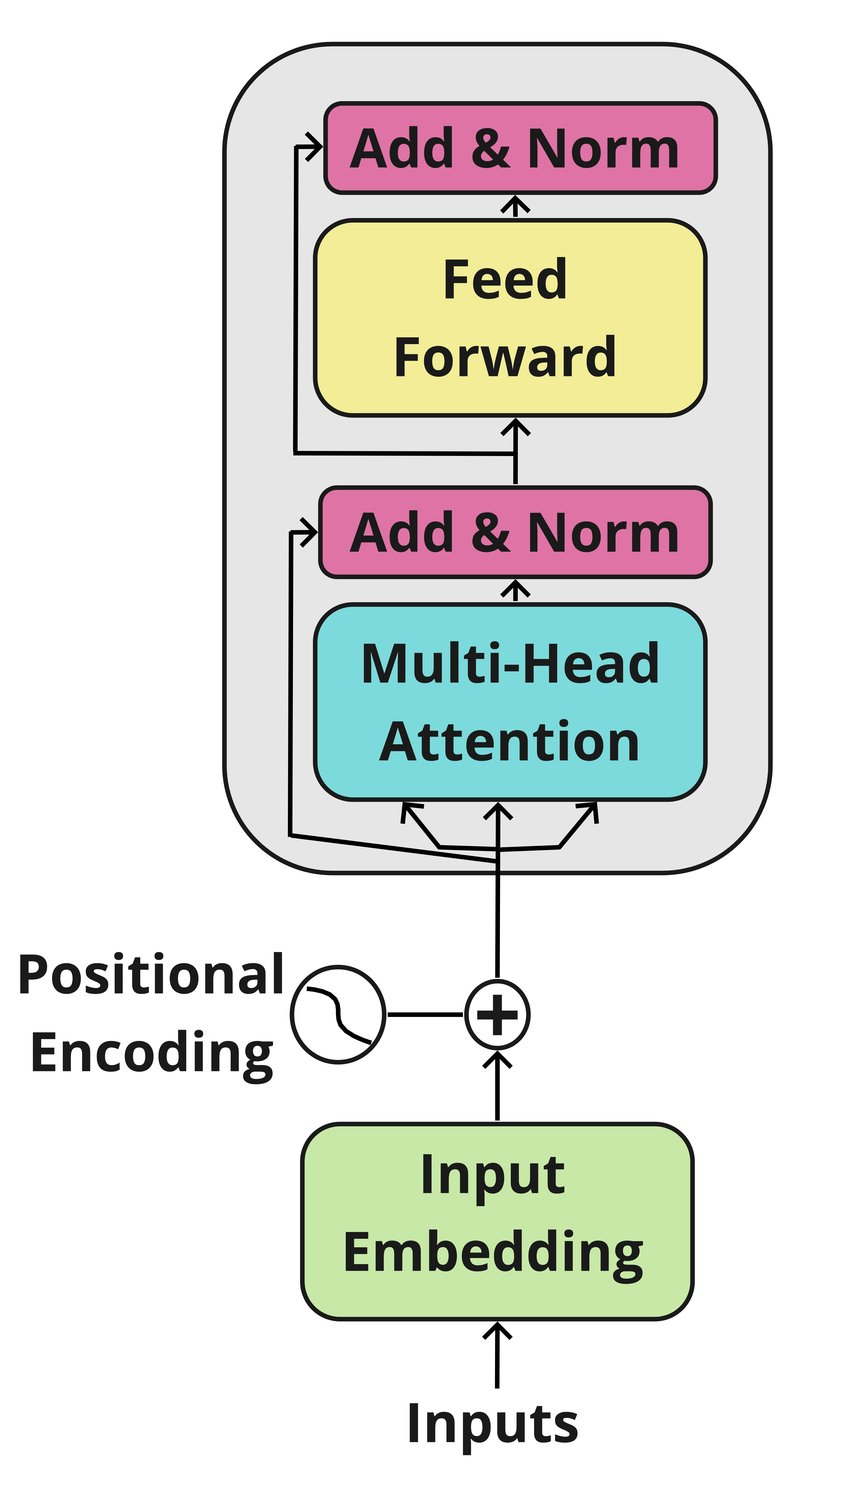

在編碼器(encoder)部分 -

* 步驟1：首先，輸入（對應於句子的填充標記）通過嵌入層和位置編碼層。

程式碼提示 假設我們有32x10的輸入（批量(batch)大小=32，序列(sequence)長度=10）。一旦它通過嵌入層，它變為32x10x512。然後將其與對應的位置編碼向量相加，產生32x10x512的輸出。這將傳遞到多頭注意力

* 步驟2：如上所述，它將通過多頭注意力層並創建有用的表示矩陣作為輸出。

程式碼提示 多頭注意力的輸入將是32x10x512，從中生成鍵、查詢和值向量，最終產生32x10x512的輸出。

* 步驟3：接下來我們有一個正規化和殘差連接。多頭注意力的輸出與其輸入相加，然後進行正規化。

程式碼提示 多頭注意力的輸出，即32x10x512，與32x10x512的輸入（由嵌入向量創建的輸出）相加，然後該層被正規化。

* 步驟4：接下來我們有一個前饋層，然後是一個正規化層，並且從輸入（前饋層的輸入）有殘差連接，我們將正規化後的輸出通過它，最終得到編碼器的輸出。

程式碼提示 正規化的輸出將是32x10x512的維度。這通過2個線性層：32x10x512 -> 32x10x2048 -> 32x10x512。最後我們有一個殘差連接，它與輸出相加，並且該層被正規化。因此，創建了一個32x10x512維度的向量作為編碼器的輸出。

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,key,query,value):

        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block

        """

        attention_out = self.attention(key,query,value)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #32x10x512

        return norm2_out



class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention

    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])

    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

# 5.解碼器(Decoder)
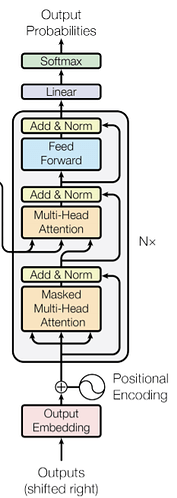

現在我們已經經歷了編碼器的大部分部分。讓我們進入解碼器的組件。我們將使用編碼器的輸出來為解碼器生成鍵和值向量。解碼器中有兩種多頭注意力。一種是解碼器注意力，另一種是編碼器解碼器注意力。別擔心，我們將一步一步進行。

讓我們以訓練階段為例來解釋。

* **步驟1：**

首先，輸出通過嵌入和位置編碼來創建一個維度為1x512的嵌入向量，對應於目標序列中的每個單詞。

程式碼提示:假設我們有一個序列(sequence)長度為10。批量(batch)大小為32，嵌入向量維度為512。我們有32x10的輸入到嵌入矩陣，它產生並輸出維度為32x10x512，它與相同維度的位置編碼相加，產生一個32x10x512的輸出

* **步驟2：**

嵌入輸出通過多頭注意力層，如前所述（從目標輸入創建鍵、查詢和值矩陣）並產生一個輸出向量。這次的主要區別是我們在多頭注意力中使用了一個遮罩。

**為什麼需要遮罩？**

遮罩的使用是因為在創建目標單詞的注意力時，我們不需要一個單詞查看未來的單詞來檢查依賴性。也就是說，我們已經知道為什麼我們創建注意力，因為我們需要知道每個單詞與其他單詞的交互的影響。由於我們正在為目標序列中的單詞創建注意力，我們不需要一個特定的單詞來查看未來的單詞。例如：在單詞"I am a student"中，我們不需要單詞"a"來查看單詞"student"。

程式碼提示:為了創建注意力，我們創建了一個由1和0組成的三角矩陣。例如：序列長度為5的三角矩陣如下：

1 0 0 0 0

1 1 0 0 0

1 1 1 0 0

1 1 1 1 0

1 1 1 1 1


在鍵與查詢相乘後，我們將所有零位置填充為負無窮大，在代碼中我們將其填充為一個非常小的數字以避免除法錯誤。 （用-1e 20）

* **步驟3：**

如前所述，我們有一個添加和規範層，我們將嵌入的輸出與注意力輸出相加，然後將其規範化。

* **步驟4：**

接下來我們有另一個多頭注意力，然後是一個添加和規範層。這個多頭注意力被稱為編碼器-解碼器多頭注意力。對於這個多頭注意力，我們從編碼器的輸出中創建鍵和值向量。查詢是從前一個解碼器層的輸出中創建的。

程式碼提示：因此，我們有32x10x512的編碼器輸出。從中生成所有單詞的鍵和值。同樣，查詢矩陣是從解碼器的前一層輸出（32x10x512）生成的。

因此，它通過一個多頭注意力（我們使用的頭數=8），然後通過一個添加和規範層。這裡，前一個編碼器層的輸出（即前一個添加和規範層的輸出）與編碼器-解碼器注意力的輸出相加，然後被規範化。

* **步驟5：**

接下來我們有一個前饋層（線性層）與添加和規範，這與編碼器中的類似。

* **步驟6：**

最後，我們創建一個線性層，長度等於目標語料庫中的單詞數量，並且與它一起有一個softmax函數來獲得每個單詞的概率。

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads

        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)


    def forward(self, key, query, x,mask):

        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention
        Returns:
           out: output of transformer block

        """

        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512
        value = self.dropout(self.norm(attention + x))

        out = self.transformer_block(key, query, value)


        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8)
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):

        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """


        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)

        out = F.softmax(self.fc_out(x))

        return out

最後，我們將設定好所有子模組並能創建整個變壓器架構。



In [7]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()

        """
        Args:
           embed_dim:  dimension of embedding
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention

        """

        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)


    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]

            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)


        return out_labels

    def forward(self, src, trg):
        """
        Args:
            src: input to encoder
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)

        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

# 6.測試程式碼

假設我們有長度為10的輸入序列和長度為10的目標序列。

In [8]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1],
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1],
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

print(src.shape,target.shape)
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size,
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)
model

torch.Size([2, 12]) torch.Size([2, 12])


Transformer(
  (encoder): TransformerEncoder(
    (embedding_layer): Embedding(
      (embed): Embedding(11, 512)
    )
    (positional_encoder): PositionalEmbedding()
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=64, out_features=64, bias=False)
          (key_matrix): Linear(in_features=64, out_features=64, bias=False)
          (value_matrix): Linear(in_features=64, out_features=64, bias=False)
          (out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 